Based of scores-sepehr, goal is to see how to create an interactive table of top 5 directors per country for the datastory

In [1]:
from helpers.readers import read_dataframe_parquet, read_dataframe

In [2]:
%%time
cmu_movies_og = read_dataframe("cmu/movies")

CPU times: total: 453 ms
Wall time: 475 ms


In [3]:
%%time
cmu_movies = read_dataframe_parquet("cmu/movies")

CPU times: total: 266 ms
Wall time: 119 ms


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from helpers.readers import prepare_dataframes

In [5]:
%%time
#movies, directors, awards = prepare_dataframes(use_parquet=False, save=True)

CPU times: total: 0 ns
Wall time: 0 ns


In [6]:
%%time
#movies, directors, awards = prepare_dataframes(use_parquet=True, save=True)

CPU times: total: 0 ns
Wall time: 0 ns


In [7]:
movies = read_dataframe_parquet("merged/movies")
directors = read_dataframe_parquet("merged/directors")
awards = read_dataframe_parquet("merged/awards")

In [8]:
all_countries = movies["countries"]
split_countries = all_countries.str.split(',')
flat_list = [country.strip() for sublist in split_countries for country in sublist]
countries = sorted(set(flat_list))
print(f'We have movies from {len(countries)} countries in the world.')

We have movies from 143 countries in the world.


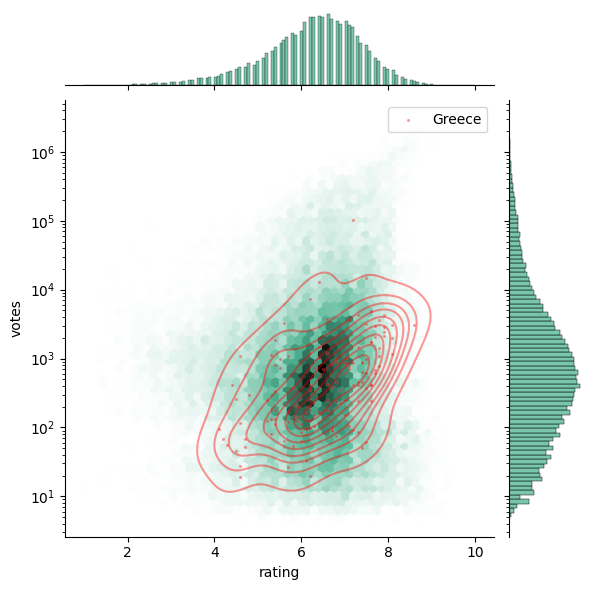

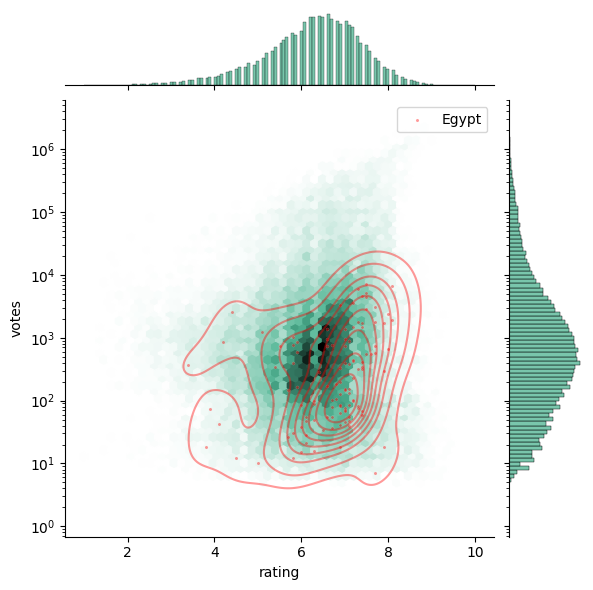

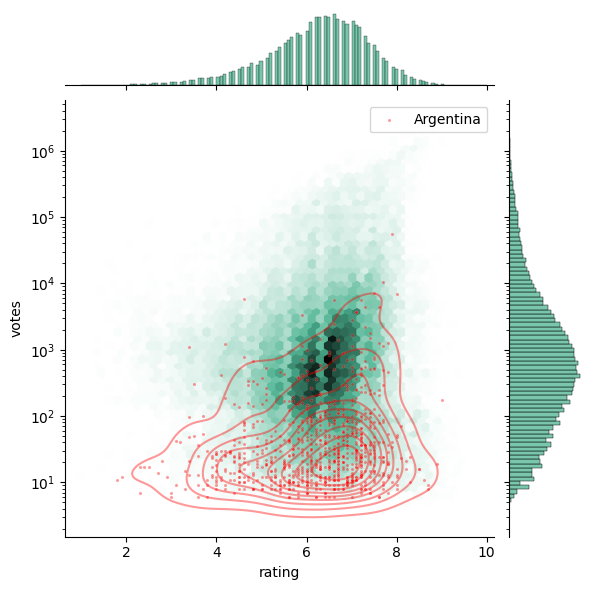

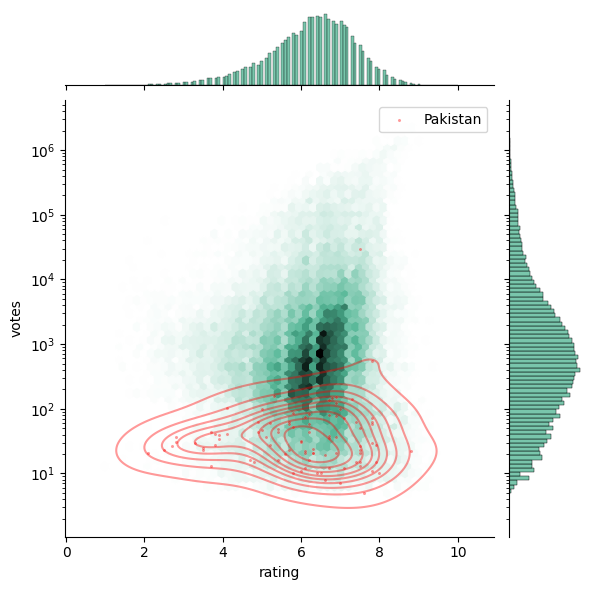

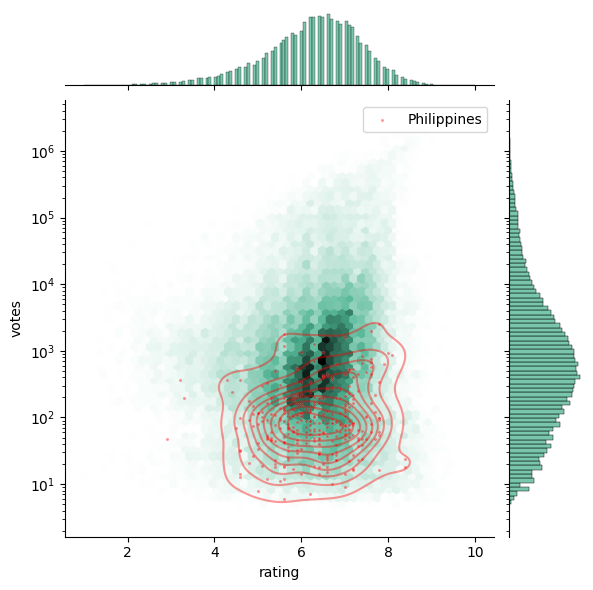

In [9]:
# NOTE: This can be an interactive plot in the final data story

for country in ['Greece']#, 'Egypt', 'Argentina', 'Pakistan', 'Philippines']:
    g = sns.jointplot(x=movies.rating, y=movies.votes, kind='hex', color="#4CB391", joint_kws={'yscale': 'log'})
    df = movies[movies.countries.str.contains(country) & ~movies.countries.str.contains(',')]
    sns.scatterplot(x=df.rating, y=df.votes, color='r', alpha=.4, s=5, ax=g.ax_joint, label=country)
    sns.kdeplot(x=df.rating, y=df.votes, color='r', alpha=.4, ax=g.ax_joint)
    g.ax_joint.legend()

In [10]:
def metric(row):
    return np.log10(row['votes']) * row['rating']

movies['score'] = movies.apply(metric, axis=1)

In [11]:
def list_top_movies(country: str, top=10):
    cols = ['title', 'score', 'rating', 'votes', 'revenue', 'release', 'genres']
    display(movies[movies.countries.str.contains(country)].sort_values(by='score', ascending=False)[:top][cols])

In [12]:
list_top_movies('Iran', top=10)

,title,score,rating,votes,revenue,release,genres
tconst,,,,,,,
tt1832382,A Separation,44.848721,8.3,253198.0,NaN,2011,Drama
tt0118849,Children of Heaven,40.132846,8.2,78388.0,1628579.0,1997,"Family Film,Drama,Adventure,World cinema,Comedy"
tt1360860,About Elly,37.510196,7.9,55992.0,1350000.0,2009,"Mystery,Drama,World cinema"
tt0416960,Marmoulak,36.448384,8.4,21832.0,NaN,2004,Comedy
tt0100234,Close-up,35.589689,8.2,21888.0,NaN,1990,"Crime Fiction,Drama,World cinema,Documentary"
tt0120265,Taste of Cherry,34.945468,7.7,34544.0,NaN,1997,"Drama,World cinema"
tt0424227,Turtles Can Fly,34.475849,8.0,20393.0,NaN,2004,"Drama,Childhood Drama,World cinema,War film"
tt0191043,The Color of Paradise,34.452236,8.1,17921.0,NaN,2000,"Family Drama,Drama,Childhood Drama,World cinema"
tt0093342,Where Is the Friend's Home?,34.331630,8.1,17317.0,NaN,1987,"Drama,Childhood Drama"


In [ ]:
%%time
def metric(director):
    directed_movies = movies[movies.directors.str.contains(director.name)]
    score = {
        'hits-30': (directed_movies.score > 30).sum(),
        'hits-40': (directed_movies.score > 40).sum(),
        'hits-45': (directed_movies.score > 45).sum(),
        'hits-50': (directed_movies.score > 50).sum(),
        'rate-7.0': len(directed_movies.query('rating >= 7.0 & votes >= 1000')),
        'rate-7.5': len(directed_movies.query('rating >= 7.5 & votes >= 1000')),
        'rate-8.0': len(directed_movies.query('rating >= 8.0 & votes >= 1000')),
        'rate-8.5': len(directed_movies.query('rating >= 8.5 & votes >= 1000')),
    }
    for n in [3, 5, 10]:
        if len(directed_movies.score.dropna()) < n:
            score[f'avg-{n}'] = pd.NA
        else:
            score[f'avg-{n}'] = directed_movies.score.sort_values(ascending=False)[:n].mean()

    return score


# Apply the metrics on one column (nested)
directors['score'] = directors.apply(metric, axis=1)

In [ ]:
%%time
# Put the socres in different columns
for key in directors.iloc[0].score.keys():
    directors[key] = directors.apply(lambda d: d.score[key], axis=1)

# Drop the extra column
directors.drop('score', axis=1, inplace=True)